# Clustering
Clustering of unlabeled data can be performed with the module `sklearn.cluster`.

Each clustering algorithm comes in two variants: a class, that implements the `fit` method to learn the clusters on train data, and a function, that, given train data, returns an array of integer labels corresponding to the different clusters. For the class, the labels over the training data can be found in the `labels_` attribute.

## K-means
The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (see below). This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields.

The k-means algorithm divides a set of $N$ samples $X$ into $K$ disjoint clusters $C$, each described by the mean $\mu_j$ of the samples in the cluster. The means are commonly called the cluster “centroids”; note that they are not, in general, points from $X$, although they live in the same space.

The K-means algorithm aims to choose centroids that _minimise_ the **inertia**, or **within-cluster sum-of-squares criterion**:
$$
\sum_{i=0}^n\min_{\mu_j\in C}(||x_i-\mu_j||^2)
$$

Inertia can be recognized as a measure of how internally coherent clusters are. It suffers from various drawbacks:

- Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.
- Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called _“curse of dimensionality”_). Running a dimensionality reduction algorithm such as Principal component analysis (**PCA**) prior to k-means clustering can alleviate this problem and speed up the computations.

K-means is often referred to as Lloyd’s algorithm. In basic terms, the algorithm has three steps. The first step chooses the initial centroids, with the most basic method being to choose $k$ samples from the dataset $X$. After initialization, K-means consists of looping between the two other steps. The first step assigns each sample to its nearest centroid. The second step creates new centroids by taking the mean value of all of the samples assigned to each previous centroid. The difference between the old and the new centroids are computed and the algorithm repeats these last two steps until this value is less than a threshold. In other words, it repeats until the centroids do not move significantly.


K-means is equivalent to the expectation-maximization algorithm with a small, all-equal, diagonal covariance matrix.

The algorithm can also be understood through the concept of Voronoi diagrams. First the Voronoi diagram of the points is calculated using the current centroids. Each segment in the Voronoi diagram becomes a separate cluster. Secondly, the centroids are updated to the mean of each segment. The algorithm then repeats this until a stopping criterion is fulfilled. Usually, the algorithm stops when the relative decrease in the objective function between iterations is less than the given tolerance value. This is not the case in this implementation: iteration stops when centroids move less than the tolerance.

Given enough time, K-means will always converge, however this may be to a local minimum. This is highly dependent on the initialization of the centroids. As a result, the computation is often done several times, with different initializations of the centroids. One method to help address this issue is the k-means++ initialization scheme, which has been implemented in scikit-learn (use the `init='k-means++'` parameter). This initializes the centroids to be (generally) distant from each other, leading to probably better results than random initialization, as shown in the reference.

K-means++ can also be called independently to select seeds for other clustering algorithms, see sklearn.cluster.kmeans_plusplus for details and example usage.

The algorithm supports sample weights, which can be given by a parameter sample_weight. This allows to assign more weight to some samples when computing cluster centers and values of inertia. For example, assigning a weight of 2 to a sample is equivalent to adding a duplicate of that sample to the dataset $X$.

K-means can be used for vector quantization. This is achieved using the transform method of a trained model of KMeans.

### K-means Example - Demonstration of k-means assumptions
This example is meant to illustrate situations where k-means will produce unintuitive and possibly unexpected clusters. In the first three plots, the input data does not conform to some implicit assumption that k-means makes and undesirable clusters are produced as a result. In the last plot, k-means returns intuitive clusters despite unevenly sized blobs.

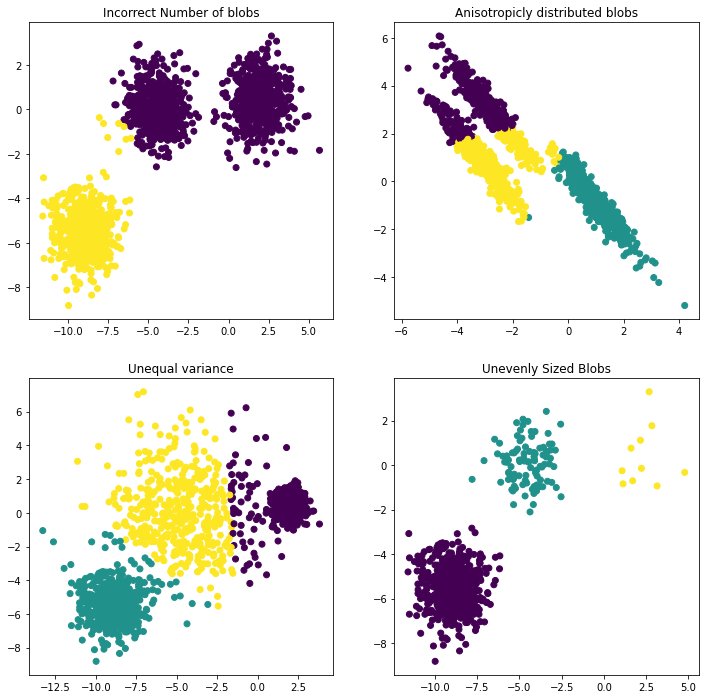

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(12,12))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:,0], X[:,1], c=y_pred)
plt.title("Incorrect Number of blobs")

# Anisotropicly distributed data
# transform data by multiplying transformation with X
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]] 
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:,0], X_aniso[:,1], c=y_pred)
plt.title("Anisotropicly distributed blobs")

# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0,2.5,0.5], random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:,0], X_varied[:,1], c=y_pred)
plt.title("Unequal variance")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")

plt.show()


### K-means Example - A demo of K-Means clustering on the handwritten digits data

In this example we compare the various initialization strategies for K-means in terms of runtime and quality of the results.

As the ground truth is known here, we also apply different cluster quality metrics to judge the goodness of fit of the cluster labels to the ground truth.

Cluster quality metrics evaluated (see [Clustering performance evaluation](https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation) for definitions and discussions of the metrics):
- homogeneity score (homo)
- completeness score (comp)
- V measure (v-meas)
- adjusted Rand Index (ARI)
- adjusted mutual information (AMI)
- silhouette coefficient (silhouette)


#### Load the dataset
We will start by loading the `digits` dataset. This dataset contains handwritten digits from 0 to 9. In the context of clustering, one would like to group images such that the handwritten digits on the image are the same.

In [3]:
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size
print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [4]:
np.unique(labels)
data.shape

(1797, 64)

#### Define our evaluation benchmark
We will first our evaluation benchmark. During this benchmark, we intend to compare different initialization methods for KMeans. Our benchmark will:

- create a pipeline which will scale the data using a [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler);
- train and time the pipeline fitting;
- measure the performance of the clustering obtained via different metrics.

In [5]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods

    Args:
        kmeans (sklearn.cluster.KMeans): KMeans instance with the initialization already set.
        name (str): Name given to the strategy. It will be used to show the results in a table
        data (np.ndarray of shape (n_samples, n_features)): The data to cluster
        labels (np.ndarray of shape (n_samples, )): The labels used to compute the clustering metrics 
                                                    which requires some supervision
    """
    
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]
    
    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score
    ]
    results += [metric(labels, estimator[-1].labels_) for metric in clustering_metrics]
    
    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric='euclidean',
            sample_size=300
        )
    ]
    
    # Show the results
    formatter_results = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_results.format(*results))

-------
[\* Operator](https://towardsdatascience.com/unpacking-operators-in-python-306ae44cd480)

In [6]:
num_list1 = [0,1,2,3,4]
num_list2 = [5,6,7,8,9]
num_list_no_op = [num_list1, num_list2] 
num_list = [*num_list1, *num_list2]
print(*num_list1)
print(num_list_no_op)
print(num_list)

0 1 2 3 4
[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [7]:
name = "Michael"
first, *mid, last = name
first, last, mid

('M', 'l', ['i', 'c', 'h', 'a', 'e'])

In [8]:
*names, = "Michael", "John", "Nancy" # names 
names

['Michael', 'John', 'Nancy']

------

#### Run the benchmark
We will compare three approaches:
- an initialization using `kmeans++`. This method is stochastic and we will run the initialization 4 times;
- a random initialization. This method is stochastic as well and we will run the initialization 4 times;
- an initialization based on a PCA projection. Indeed, we will use the components of the PCA to initialize KMeans. This method is deterministic and a single initialization suffice.

In [9]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * '_')
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name='k-means++', data=data, labels=labels)

kmeans = KMeans(init='random', n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name='random', data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name='PCA-based', data=data, labels=labels)

print(82 * '_')


__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.066s	69662	0.680	0.719	0.699	0.570	0.695	0.180
random   	0.041s	69707	0.675	0.716	0.694	0.560	0.691	0.178
PCA-based	0.021s	74152	0.653	0.683	0.668	0.539	0.664	0.143
__________________________________________________________________________________


#### Visualize the results on PCA-reduced data
PCA allows to project the data from the original 64-dimensional space into a lower dimensional space. Subsequently, we can use PCA to project into a 2-dimensional space and plot the data and the clusters in this new space.

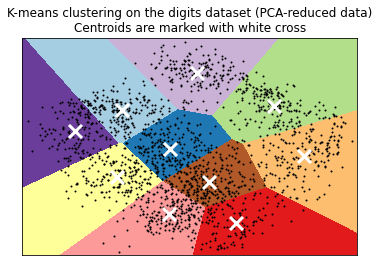

In [10]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02 # point in the mesh [x_min, x_max]x[y_min, y_max]

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:,0].min() - 1, reduced_data[:,0].max() + 1
y_min, y_max = reduced_data[:,1].min() - 1, reduced_data[:,1].max() + 1

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation='nearest',
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect='auto',
    origin='lower'
)

plt.plot(reduced_data[:,0], reduced_data[:,1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:,0],
    centroids[:,1],
    marker='x',
    s=170,
    linewidths=3,
    color='w',
    zorder=10
)

plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### Mini Batch K-means
The [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans) is a _variant_ of the KMeans algorithm which uses __mini-batches to reduce the computation time__, while still attempting to optimise the same objective function. Mini-batches are subsets of the input data, randomly sampled in each training iteration. These mini-batches drastically reduce the amount of computation required to converge to a local solution. In contrast to other algorithms that reduce the convergence time of k-means, mini-batch k-means produces results that are generally only slightly worse than the standard algorithm.

The algorithm iterates between two major steps, similar to vanilla k-means. In the first step, $b$ samples are drawn randomly from the dataset, to form a mini-batch. These are then assigned to the nearest centroid. In the second step, the centroids are updated. In contrast to k-means, this is done on a per-sample basis. For each sample in the mini-batch, the assigned centroid is updated by taking the streaming average of the sample and all previous samples assigned to that centroid. This has the effect of decreasing the rate of change for a centroid over time. These steps are performed until convergence or a predetermined number of iterations is reached.

__MiniBatchKMeans converges faster than KMeans, but the quality of the results is reduced.__ In practice this difference in quality can be quite small.

### Mini Batch K-means Example - Comparison of the K-Means and MiniBatchKMeans clustering algorithms

We want to compare the performance of the MiniBatchKMeans and KMeans: the MiniBatchKMeans is faster, but gives slightly different results.

We will cluster a set of data, first with KMeans and then with MiniBatchKMeans, and plot the results. We will also plot the points that are labelled differently between the two algorithms.

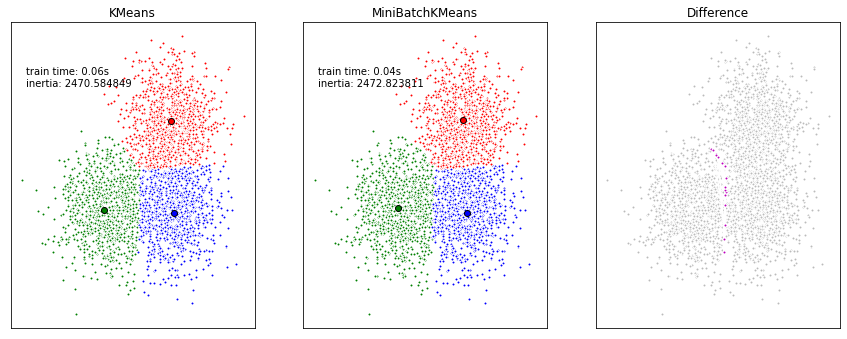

In [18]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

#### Generate sample data ####
np.random.seed(0)

batch_size = 45
centers = [[1,1], [-1,-1], [1,-1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)
#### Generate sample data ####

#### Compute clustering with K Means ####
k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
t0 = time()
k_means.fit(X)
t_batch = time() - t0
#### Compute clustering with K Means ####

#### Compute clustering with Mini Batch K Means ####
mbk = MiniBatchKMeans(
    n_clusters=3,
    init='k-means++',
    batch_size=batch_size,
    n_init=10,
    max_no_improvement=10,
    verbose=0,
)

t0 = time()
mbk.fit(X)
t_mini_batch = time() - t0
#### Compute clustering with Mini Batch K Means ####

#### Plot the results ####
fig = plt.figure(figsize=(12,5))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
# colors = ["#4EACC5", "#FF9C34", "#4E9A06"]
colors = ["g", "b", "r"]

# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.
k_means_cluster_centers = k_means.cluster_centers_
# for each row in k_means_cluster_centers returns the index of mbk_cluster_centers 
# whose values are the closest to those of the row in k_means_cluster_centers
order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

# associate labels to values of X
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

# KMeans
ax = fig.add_subplot(1,3,1) #1 row, 3 columns, 1st position
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members,1], 'w', markerfacecolor=col, marker='.')
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        'o',
        markerfacecolor=col,
        markeredgecolor='k',
        markersize=6,
    )
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_batch, k_means.inertia_))


# Mini Batch KMeans
ax = fig.add_subplot(1,3,2) #1 row, 3 columns, 2nd position
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    # plot points
    ax.plot(X[my_members,0], X[my_members,1], "w", markerfacecolor=col, marker='.')
    # plot centers
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor='k',
        markersize=6
    )
ax.set_title("MiniBatchKMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_mini_batch, mbk.inertia_))


# Plot the differences
# Initialise the different array to all False
different = mbk_means_labels == 4 # 4 is not a cluster
ax = fig.add_subplot(1,3,3)

for k in range(n_clusters):
    different += (k_means_labels == k) != (mbk_means_labels == k)

identic = np.logical_not(different)
ax.plot(X[identic,0], X[identic,1], "w", markerfacecolor="#bbbbbb", marker='.')
ax.plot(X[different,0], X[different,1], "w", markerfacecolor="m", marker='.')
ax.set_title("Difference")
ax.set_xticks(())
ax.set_yticks(())

plt.show()
#### Plot the results ####

In [16]:

k_means_cluster_centers
mbk_means_cluster_centers

array([[-1.03319086, -0.96876381],
       [ 1.09657842, -1.06909628],
       [ 0.97209774,  1.02960668]])

In [17]:
order

array([1, 2, 0])

In [19]:
k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]
mbk.cluster_centers_

array([[ 0.97209774,  1.02960668],
       [-1.03319086, -0.96876381],
       [ 1.09657842, -1.06909628]])

In [20]:
mbk.cluster_centers_[order]

array([[-1.03319086, -0.96876381],
       [ 1.09657842, -1.06909628],
       [ 0.97209774,  1.02960668]])

In [23]:
k_means_labels#.shape

array([1, 0, 1, ..., 0, 0, 2])